# Transform mask into COSTO .json

In [229]:
import re
from os import listdir
from os.path import join
from pipeline.image_handeling.data_utility import load_stack
from skimage.measure import find_contours, regionprops_table
from numpyencoder import NumpyEncoder
import json

def mask_to_json(mask_fold_path, save_path, channel):
  img_path = []
  for file in sorted(listdir(mask_fold_path)):
      if channel in file:
        img_path.append(join(mask_fold_path,file))
  im_num = re.findall('f\d+', str(img_path))
  max_number = max(int(x[1:]) for x in im_num)
  max_number

  img_stack = load_stack(img_paths=img_path, channels=channel, frame_range=range(max_number), return_2D=True)

  annotations_lst = []
  images_lst = []
  for frame, img in enumerate(img_stack):
    outline_region =regionprops_table(img, properties=('label','bbox','area'))
    frame_name = img_path[frame].rsplit('/',1)[1]
    labels = outline_region['label']
    bbox0 = outline_region['bbox-0']
    bbox1 = outline_region['bbox-1']
    bbox2 = outline_region['bbox-2']
    bbox3 = outline_region['bbox-3']
    area = outline_region['area']

    for i in range(labels.shape[0]):
        label = labels[i]
        segmentation_lst=[]
        regionmask=(img==label)
        coords = find_contours(regionmask)
        for y,x in coords[0]:
            segmentation_lst.append(x+0.5)
            segmentation_lst.append(y+0.5)
        
        annotations_lst.append({'id':label, 
                                'image_id':frame+1,
                                'category_id':1,
                                'segmentation':[segmentation_lst],
                                'area':area[i],
                                'bbox':[bbox0[i], bbox1[i], bbox2[i], bbox3[i]],
                                'iscrowd': 0,
                                'attributes': {'occluded': False}})

    images_lst.append({'id': frame+1,
              'width': img.shape[1],
              'height': img.shape[0],
              'file_name': frame_name,
              'license': 0,
              'flickr_url': '',
              'coco_url': '',
              'date_captured': 0})

  json_dict = {'licenses': [{'name': '', 'id': 0, 'url': ''}],
          'info': {'contributor': '',
            'date_created': '',
            'description': '',
            'url': '',
            'version': '',
            'year': ''},
          'categories': [{'id': 1, 'name': 'Cell', 'supercategory': ''}],
          'images': images_lst,
          'annotations':annotations_lst}

  with open(save_path, "w") as file:
      json.dump(json_dict, file, cls=NumpyEncoder)

In [230]:

mask_folder = '/home/Fabian/ImageData/TrackingTestFiles/NeutrophilTrackingTest/mfap4-mpx_isohypo_2h_WT-MaxIP_s1/Masks_Cellpose'
channel = 'GFP'
savefile = '/home/Fabian/ImageData/Seriestest.json'

mask_to_json(mask_fold_path=mask_folder, save_path=savefile, channel=channel)

[array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)]


# Reconstruct mask based on COSTO .json

In [231]:
import json
import numpy as np
from skimage.draw import polygon2mask

def mask_from_json(path):
    file = open(path)
    json_file = json.load(file)

    mask_lst = []
    name_lst = []
    width = json_file['images'][0]['width']
    height = json_file['images'][0]['height']
    annotations = json_file['annotations']
    n_frame = len(json_file['images'])
    mask = np.zeros((n_frame,width,height), dtype='int')
    for images in json_file['images']:
        name_lst.append(images['file_name'])
    for annot in annotations:
        segmentation = annot['segmentation'][0]
        id = int(annot['id'])
        frame_id = int(annot['image_id'])
        coord_lst = []
        for point in range(0, len(segmentation),2):
            coord_lst.append((round(segmentation[point+1]), round(segmentation[point])))
        tempmask =  polygon2mask((width,height),coord_lst)
        tempmask[tempmask!=0] = id
        mask[frame_id-1] = mask[frame_id-1] + tempmask
    mask_lst.append(mask)
    mask_stack = np.squeeze(np.stack(mask_lst))
    return name_lst, mask_stack

In [232]:
path = '/home/Fabian/ImageData/instances_Series.json'
name_lst, mask_stack = mask_from_json(path)

In [ ]:
from matplotlib.pyplot import imshow

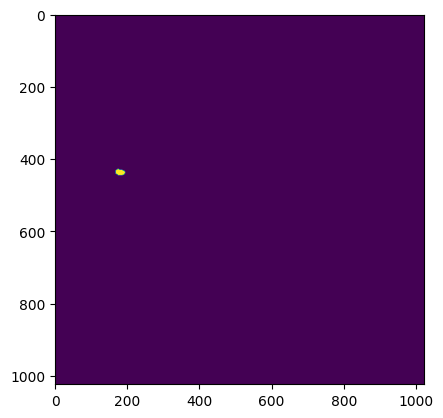

In [227]:
imshow(mask_stack[2])

In [27]:

import cv2
from platform import system
from os import listdir
from os.path import join
from pipeline.image_handeling.data_utility import load_stack
import numpy as np

In [40]:
def draw_polygons(img, frames):
    """
    Free-hand draw a polygon on loaded image. Take as input list of path files of the images.
    Usage:
        - The image will appear in popup window
        - Press either 'b' or 'f' to move frames back- or forward
        - Draw polygon
        - Press 's' to save polygon. If a polygon is drawn and save on the same frame, it will overwrite the previous one.
        - Press 'q' when ready

    Args:
        img_list ([str]): List of path file of the images.
        
    Returns:
        dict_roi (dict): Dictionary containg the coordinates of the polygons drawn for each selected frames. 
    """

    seqLeng = frames
    
    # Load images and draw
    f = 0 # Allow to move between the different frames
    dict_roi = {} # Store the polygons
    img2  = img.copy()
    alpha = 1; beta = 0
    togglemask = 0; togglelabel = 0
    conbri = 0
    while f!=-1:
        drawing=False; polygons = []; currentPt = []
        # Mouse callback function
        def freehand_draw(event,x,y,flags,param):
            nonlocal polygons, drawing, im, currentPt
            # Press mouse
            if event==cv2.EVENT_LBUTTONDOWN:
                drawing=True; polygons = []; currentPt = []
                currentPt.append([x,y])
                polygons = np.array([currentPt], np.int32)
                im = im2.copy()
            # Draw when mouse move, if pressed
            elif event==cv2.EVENT_MOUSEMOVE:
                if drawing==True:
                    cv2.polylines(im,[polygons],False,(0,255,255),2)
                    currentPt.append([x,y])
                    polygons = np.array([currentPt], np.int32)
            # Release mouse button
            elif event==cv2.EVENT_LBUTTONUP:
                drawing=False
                cv2.polylines(im,[polygons],True,(0,255,255),2)
                cv2.fillPoly(im,[polygons],(0,255,255))
                currentPt.append([x,y])
                polygons = np.array([currentPt], np.int32)
            return polygons
        
        # Read/Load image
        if seqLeng==1:
            im = cv2.resize(img,(768,768),cv2.INTER_NEAREST)
        else:
            im = cv2.resize(img[f],(768,768),cv2.INTER_NEAREST)
        im2 = im.copy()

        if togglemask == 0:
            if f in dict_roi.keys():
                cv2.polylines(im,dict_roi[f], True, (0,255,255),2)
                cv2.fillPoly(im,dict_roi[f],(0,255,255))

        cv2.namedWindow("Draw ROI of the Wound")
        cv2.setMouseCallback("Draw ROI of the Wound",freehand_draw)
        
        # Setup labels
        text = f"Frame {f+1}/{seqLeng}"; coord = (320,20)
        texts = "Press 's' to save ROI and move forward"; coords = (10,40)
        if system()=='Linux': textar = "Press 'l' to go forward"
        elif system()=='Windows': textar = "Press 'ARROW RIGHT' to go forward"
        coordar = (10,60)
        if system()=='Linux': textal = "Press 'j' to go backward"
        elif system()=='Windows': textal = "Press 'ARROW LEFT' to go backward"
        coordal = (10,80)
        textq = "Press 'q' for quit"; coordq = (10,100)
        if system()=='Linux': textc = "Press 'c' once and 'i'(up) or 'k'(down) to change contrast"
        elif system()=='Windows': textc = "Press 'c' once and 'ARROW UP/DOWN' to change contrast"
        coordc = (10,120)
        if system()=='Linux': textb = "Press 'b' once and 'i' or 'k' to change brightness"
        elif system()=='Windows': textb = "Press 'b' once and 'ARROW UP/DOWN' to change brightness"
        coordb = (10,140)
        textx = "Press 'x' to toggle mask"; coordx = (10,160)  
        textl = "Press 'h' to toggle help"; coordl = (10,180)                  

        font = cv2.FONT_HERSHEY_PLAIN; fontScale = 1.2; color = (0,255,255); thickness = 1
        
        # Apply label on images
        cv2.putText(im, text, coord, font, fontScale, color, thickness, cv2.LINE_AA)
        cv2.putText(im2, text, coord, font, fontScale, color, thickness, cv2.LINE_AA)
        if togglelabel == 0:
            cv2.putText(im, textal, coordal, font, fontScale, color, thickness, cv2.LINE_AA)
            cv2.putText(im, textar, coordar, font, fontScale, color, thickness, cv2.LINE_AA)
            cv2.putText(im, texts, coords, font, fontScale, color, thickness, cv2.LINE_AA)
            cv2.putText(im, textq, coordq, font, fontScale, color, thickness, cv2.LINE_AA)
            cv2.putText(im, textc, coordc, font, fontScale, color, thickness, cv2.LINE_AA)
            cv2.putText(im, textb, coordb, font, fontScale, color, thickness, cv2.LINE_AA)
            cv2.putText(im, textx, coordx, font, fontScale, color, thickness, cv2.LINE_AA)
            cv2.putText(im, textl, coordl, font, fontScale, color, thickness, cv2.LINE_AA)

            cv2.putText(im2, textal, coordal, font, fontScale, color, thickness, cv2.LINE_AA)
            cv2.putText(im2, textar, coordar, font, fontScale, color, thickness, cv2.LINE_AA)
            cv2.putText(im2, texts, coords, font, fontScale, color, thickness, cv2.LINE_AA)
            cv2.putText(im2, textq, coordq, font, fontScale, color, thickness, cv2.LINE_AA)
            cv2.putText(im2, textc, coordc, font, fontScale, color, thickness, cv2.LINE_AA)
            cv2.putText(im2, textb, coordb, font, fontScale, color, thickness, cv2.LINE_AA)
            cv2.putText(im2, textx, coordx, font, fontScale, color, thickness, cv2.LINE_AA)
            cv2.putText(im2, textl, coordl, font, fontScale, color, thickness, cv2.LINE_AA)
        
        while True:
            cv2.imshow("Draw ROI of the Wound",im)

            # Numbers for arrow keys
            # Windows: left: 2424832, right: 2555904, up: 2490368, down: 2621440
            # Linux: left: 65361, right: 65363, up: 65362, down: 65364

            key = cv2.waitKeyEx(1)
            if key != -1:
                print(key)
            
            # if key != -1:
            #     print(key)
            
            # press 'q' to exit.
            if key == ord("q"):
                f = -1
                conbri = 0
                break
            # press 'arrow key right' to move forward
            elif key == 2555904 or key == ord("l") or key == 65363: #ArrowKey RIGHT for Windows
                conbri = 0
                if f == seqLeng-1:
                    f = seqLeng-1
                    break
                else:
                    f += 1
                    break
            # press 'arrow key left' to move backwards
            elif key == 2424832 or key == ord("j") or key == 65361: #ArrowKey LEFT for Windows
                conbri = 0
                if f == 0:
                    f = 0
                    break
                else:
                    f -= 1
                    break
            # press 's' to save roi.
            elif key == ord("s"):
                conbri = 0
                if f == seqLeng-1:
                    dict_roi[f] = polygons
                    f = seqLeng-1
                    break
                else:
                    dict_roi[f] = polygons
                    f += 1
                    break   
            # press 'c' to activate contrast change mode
            elif key == ord("c"):
                conbri = key
            # press 'b' to activate brightness change mode
            elif key == ord("b"):
                conbri = key
            # if Arrowkey up or down is pressed, check if contrast or brightness change mode is active
            elif key == 2490368 or key == ord("i") or key == 65362: #ArrowKey UP for Windows
                if conbri == ord("c"):
                    alpha += 5
                    img = cv2.convertScaleAbs(img2, alpha=alpha, beta=beta)
                    break
                elif conbri == ord("b"):
                    beta += 5
                    img = cv2.convertScaleAbs(img2, alpha=alpha, beta=beta)  
                    break 
            elif key ==  2621440 or key == ord("k") or key == 65364: #ArrowKey DOWN for Windows
                if conbri == ord("c"):
                    alpha += -5
                    if alpha < 1:
                        alpha = 1
                    img = cv2.convertScaleAbs(img2, alpha=alpha, beta=beta)
                    break
                elif conbri == ord("b"):
                    beta += -5
                    img = cv2.convertScaleAbs(img2, alpha=alpha, beta=beta)
                    break   
            # toogle masks visibility
            elif key == ord("x"):
                if togglemask == 0:
                    togglemask = 1
                    break
                else:
                    togglemask = 0
                    break
            # toogle label visibility
            elif key == ord("h"):
                if togglelabel == 0:
                    togglelabel = 1
                    break
                else:
                    togglelabel = 0     
                    break
    cv2.destroyAllWindows()
    return dict_roi

In [20]:
image_folder = '/home/Fabian/ImageData/240502-minoSOG_mito_L10/HEKA_c1031_c1829_miniSOG_80%_435_2min_40min_002_Merged_s1/Images_Registered'
active_channel_list = ['YFP']

In [21]:
img_path = []
for file in sorted(listdir(image_folder)):
    img_path.append(join(image_folder,file))
lowercase_channels = [channel.lower() for channel in active_channel_list]
# Check if 'bf' is in the list
if 'bf' in lowercase_channels:
    index = lowercase_channels.index('bf')
    channel_lst = active_channel_list[index]
else:
    channel_lst=active_channel_list
if 'BF' in active_channel_list:
    active_channel_list = ''
img = load_stack(img_paths=img_path, channels=channel_lst, frame_range=range(126), return_2D=True)

[array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  6, ...,  0,  0,  0],
       [ 0,  0, 16, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint16)]


In [45]:
draw_polygons(img, frames=126)

98
65362
65362
65363
65363
65363
65363
65363
65361
65361
65361
65361
65361
65361
65363
65363
65363
65363
65363
65363
65363
65363
65363
65363
65361
65361
65361
65361
65361
99
65364
65364
65362
65362
65364
65364
65364
65364
98
65362
65362
65362
65364
65364
65364
65364
65364
115
115
108
108
106
106
108
108
106
106
108
120
104
104
104
104
104
104
104
113


{5: array([[[373, 364],
         [374, 349],
         [375, 335],
         [378, 319],
         [381, 314],
         [382, 313],
         [384, 313],
         [389, 312],
         [396, 311],
         [397, 311],
         [403, 311],
         [423, 314],
         [435, 315],
         [436, 315],
         [448, 321],
         [454, 324],
         [461, 328],
         [462, 330],
         [465, 334],
         [470, 340],
         [475, 350],
         [479, 359],
         [484, 367],
         [485, 371],
         [487, 381],
         [487, 383],
         [486, 390],
         [483, 396],
         [476, 403],
         [459, 413],
         [439, 421],
         [436, 422],
         [426, 423],
         [417, 423],
         [410, 421],
         [401, 418],
         [392, 414],
         [384, 409],
         [377, 403],
         [375, 398],
         [371, 389],
         [368, 383],
         [367, 378],
         [367, 376],
         [367, 374],
         [367, 372],
         [369, 370],
         [

need to import bgr image

In [35]:
import os
from os.path import join
import numpy as np
from matplotlib.pyplot import imshow
from tifffile import imwrite

In [6]:
path = '/home/Fabian/ImageData/CalciumImmunCell/Macrophage/Amputation/c1147x1382_001-MaxIP_s1/Masks_Cellpose'

In [36]:
writefolder = '/home/Fabian/ImageData/CalciumImmunCell/Macrophage/Amputation/c1147x1382_001-MaxIP_s1/Masks_Cellpose_new'

In [19]:
test_path = '/home/Fabian/ImageData/CalciumImmunCell/Macrophage/Amputation/c1147x1382_001-MaxIP_s1/Masks_Cellpose/RFP_s01_f0001_z0001_seg.npy'

In [20]:
npy_file = np.load((test_path),allow_pickle=True)

In [33]:
testfile = npy_file.item()['masks']

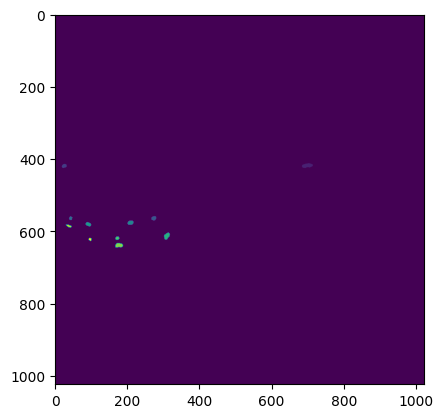

In [34]:
imshow(testfile)

In [48]:
'RFP_s01_f1440_z0001_seg.npy'.rsplit('_',1)[0]

'RFP_s01_f1440_z0001'

In [50]:
for file in os.listdir(path):
    if file.endswith('.npy'):
        npy_file_mask = np.load(join(path,file),allow_pickle=True).item()['masks']
        filename = file.rsplit('_',1)[0]
        imwrite(join(writefolder,filename+'.tif'), npy_file_mask)
        

In [15]:

sort_frame = {frame: [path for path in sorted(os.listdir(path)) if f"_f{frame+1:04d}" in path] for frame in range(23)}
sort_frame

{0: ['GFP_s01_f0001_z0001.tif',
  'GFP_s01_f0001_z0002.tif',
  'GFP_s01_f0001_z0003.tif',
  'GFP_s01_f0001_z0004.tif',
  'GFP_s01_f0001_z0005.tif',
  'GFP_s01_f0001_z0006.tif',
  'GFP_s01_f0001_z0007.tif',
  'GFP_s01_f0001_z0008.tif',
  'GFP_s01_f0001_z0009.tif',
  'GFP_s01_f0001_z0010.tif',
  'GFP_s01_f0001_z0011.tif',
  'GFP_s01_f0001_z0012.tif',
  'GFP_s01_f0001_z0013.tif',
  'GFP_s01_f0001_z0014.tif',
  'GFP_s01_f0001_z0015.tif',
  'GFP_s01_f0001_z0016.tif',
  'GFP_s01_f0001_z0017.tif',
  'GFP_s01_f0001_z0018.tif',
  'GFP_s01_f0001_z0019.tif',
  'GFP_s01_f0001_z0020.tif',
  'GFP_s01_f0001_z0021.tif',
  'GFP_s01_f0001_z0022.tif',
  'GFP_s01_f0001_z0023.tif',
  'GFP_s01_f0001_z0024.tif',
  'GFP_s01_f0001_z0025.tif',
  'RFP_s01_f0001_z0001.tif',
  'RFP_s01_f0001_z0002.tif',
  'RFP_s01_f0001_z0003.tif',
  'RFP_s01_f0001_z0004.tif',
  'RFP_s01_f0001_z0005.tif',
  'RFP_s01_f0001_z0006.tif',
  'RFP_s01_f0001_z0007.tif',
  'RFP_s01_f0001_z0008.tif',
  'RFP_s01_f0001_z0009.tif',
  'RFP_s01_

In [5]:
lst = ['GFP_s01_f0002_z0022.tif',
  'GFP_s01_f0002_z0023.tif',
  'GFP_s01_f0002_z0024.tif',
  'GFP_s01_f0002_z0025.tif',
  'RFP_s01_f0002_z0001.tif',
  'RFP_s01_f0002_z0002.tif',
  'RFP_s01_f0002_z0003.tif',
  'RFP_s01_f0002_z0004.tif',
  'RFP_s01_f0002_z0005.tif',
  'RFP_s01_f0002_z0006.tif',
  'RFP_s01_f0002_z0007.tif',]
order = ['RFP', 'GFP']
def custom_sort_key(name):
    try:
        return order.index(name)
    except ValueError:
        return len(order)
sorted(lst, key=order.index['RFP'])

TypeError: 'builtin_function_or_method' object is not subscriptable

In [1]:
from nd2 import ND2File

path = '/home/Test_images/nd2/Run3/c3z1t1v3.nd2'
with ND2File(path) as value:
    nd2meta = {**value.sizes}
    nd2meta['um_per_pixel'] = value.metadata.channels[0].volume.axesCalibration[:2]
    nd2meta['T'] = 1 if 'T' not in nd2meta else nd2meta['T']
    if nd2meta['T']>1:
        nd2meta['interval_sec'] = value.experiment[0].parameters.periodMs/1000
    else:
        nd2meta['interval_sec'] = None
    value.close()
    
nd2meta['T'] = 1 if 'T' not in nd2meta else nd2meta['T']
nd2meta['C'] = 1 if 'C' not in nd2meta else nd2meta['C']
nd2meta['Z'] = 1 if 'Z' not in nd2meta else nd2meta['Z']
nd2meta['P'] = 1 if 'P' not in nd2meta else nd2meta['P']

original_keys = ['C', 'Z', 'T', 'P', 'X', 'Y']
new_keys = ['full_n_channels', 'n_slices', 'n_frames', 'n_series', 'img_width', 'img_length']

for i, key in enumerate(original_keys):
    nd2meta[new_keys[i]] = nd2meta.pop(key)

nd2meta['axes'] = ''
nd2meta['file_type'] = '.nd2'

nd2meta

{'um_per_pixel': (0.325, 0.325),
 'interval_sec': None,
 'full_n_channels': 3,
 'n_slices': 1,
 'n_frames': 1,
 'n_series': 3,
 'img_width': 1024,
 'img_length': 1024,
 'axes': '',
 'file_type': '.nd2'}

In [2]:
with ND2File(path) as value:
    arr = value.asarray()
    value.close()
arr.shape

(3, 3, 1024, 1024)

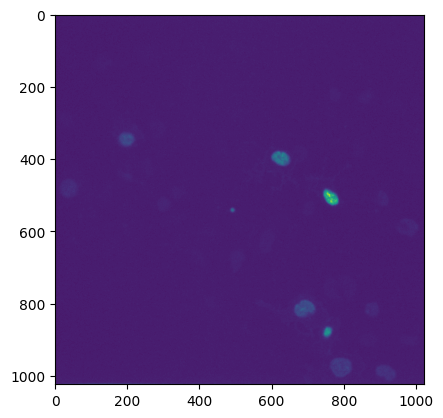

In [17]:
from matplotlib.pyplot import imshow
imshow(arr[(0,2)])

In [8]:
from __future__ import annotations
from tifffile import TiffFile

img_path = '/home/Test_images/tiff/Run3/c3z1t1v3s1.tif'

def calculate_um_per_pixel(meta_dict: dict) -> tuple[float,float]:
    """Calculate the um per pixel from the metadata of a tiff file. Output axes = (x,y)"""
    x_um_per_pix = round(1/meta_dict['XResolution'],ndigits=3)
    y_um_per_pix = round(1/meta_dict['YResolution'],ndigits=3)
    return x_um_per_pix,y_um_per_pix


tiff_meta = {}
# Open tif and read meta
with TiffFile(img_path) as tif:
    imagej_meta = tif.imagej_metadata
    imagej_meta['axes'] = tif.series[0].axes
    for page in tif.pages: # Add additional meta
        for tag in page.tags:
            if tag.name in ['ImageWidth','ImageLength',]:
                imagej_meta[tag.name] = tag.value
            if tag.name in ['XResolution','YResolution']:
                imagej_meta[tag.name] = tag.value[0]/tag.value[1]

if 'frames' not in imagej_meta: imagej_meta['frames'] = 1

if 'channels' not in imagej_meta: imagej_meta['channels'] = 1

if 'slices' not in imagej_meta: imagej_meta['slices'] = 1

if 'finterval' not in imagej_meta: 
    imagej_meta['finterval'] = None
else:
    imagej_meta['finterval'] = int(imagej_meta['finterval'])

original_keys = ['ImageWidth','ImageLength','frames','channels','slices','axes','finterval']
new_keys = ['img_width','img_length','n_frames','full_n_channels','n_slices','axes','interval_sec']

for i, key in enumerate(original_keys):
    tiff_meta[new_keys[i]] = imagej_meta[key]


tiff_meta['n_series'] = 1
tiff_meta['um_per_pixel'] = calculate_um_per_pixel(imagej_meta)

tiff_meta['file_type'] = '.tif'
tiff_meta

{'img_width': 1024,
 'img_length': 1024,
 'n_frames': 1,
 'full_n_channels': 3,
 'n_slices': 1,
 'axes': 'CYX',
 'interval_sec': None,
 'n_series': 1,
 'um_per_pixel': (0.325, 0.325),
 'file_type': '.tif'}

In [11]:
s = 'TZCYX'
s.replace('T','')

'ZCYX'

In [2]:
settings = {
    "input_folder": '/home/Test_images/nd2/Run2',
    "init":{"active_channel_list": ['GFP','RFP'],
            'full_channel_list':[],
            "overwrite": True},
    
    
    "run_bg_sub": (True,
                {"sigma": 0.0,
                "size": 7,
                "overwrite": False}),
    
    "run_channel_reg": (False,
                    {"reg_channel": "RFP",
                    "reg_mtd": "rigid_body",
                    "overwrite": False}),
    
    "run_frame_reg": (False,
                {"reg_channel": "RFP",
                "reg_mtd": "rigid_body",
                "img_ref": "previous",
                "overwrite": True}),
    
    "run_blur": (False,
            {"kernel": (15,15),
            "sigma": 5,
            "img_fold_src": "",
            "overwrite": False}),

    "run_cellpose": (False,
                {"channel_to_seg":"RFP",
                "model_type": "cyto3",
                "diameter": 60.0,
                "flow_threshold": 0.4,
                "cellprob_threshold": 0.0,
                "overwrite": False,
                "img_fold_src": "",
                "process_as_2D": True,
                "save_as_npy": False,
                "nuclear_marker": "",}),
    
    "run_threshold": (False,
                {"channel_to_seg":"RFP",
                "overwrite": True,
                "manual_threshold": None,
                "img_fold_src": "",}),
}
pre = {}
seg = {}
for k,v in settings.items():
    if k in ["run_bg_sub","run_channel_reg","run_frame_reg","run_blur"] and v[0]:
        pre[k] = v[1]
    
    if k in ["run_cellpose","run_threshold"] and v[0]:
        seg[k] = v[1]
print(seg)

{}


In [4]:
lsty = [False, False, False]
any(lsty)

False

In [1]:
from __future__ import annotations
from dataclasses import dataclass, field, fields

settings = {
    "input_folder": '/home/Test_images/nd2/Run2',
    "init":{"active_channel_list": ['GFP','RFP'],
            'full_channel_list':[],
            "overwrite": True},
    
    
    "bg_sub": (True,
                {"sigma": 0.0,
                "size": 7,
                "overwrite": True}),
    
    "chan_shift": (True,
                    {"reg_channel": "RFP",
                    "reg_mtd": "rigid_body",
                    "overwrite": False}),
    
    "frame_shift": (False,
                {"reg_channel": "RFP",
                "reg_mtd": "rigid_body",
                "img_ref": "previous",
                "overwrite": True}),
    
    "blur": (True,
            {"kernel": (15,15),
            "sigma": 5,
            "img_fold_src": "",
            "overwrite": False}),

    "cellpose": (False,
                {"channel_to_seg":"RFP",
                "model_type": "cyto3",
                "diameter": 60.0,
                "flow_threshold": 0.4,
                "cellprob_threshold": 0.0,
                "overwrite": False,
                "img_fold_src": "",
                "process_as_2D": True,
                "save_as_npy": False,
                "nuclear_marker": "",}),
    
    "threshold": (False,
                {"channel_to_seg":"RFP",
                "overwrite": True,
                "manual_threshold": None,
                "img_fold_src": "",}),
    
    "iou_track": (True,
                  {"channel_to_track":"RFP",
                   "img_fold_src": "",
                   "stitch_thres_percent": 0.75,
                   "shape_thres_percent": 0.2,
                   "n_mask":5,
                   "overwrite":False})
}

@dataclass
class BaseSettings:
    def __post_init__(self)-> None:
        # Get all the branch names of the class
        branch_name = [f.name for f in fields(self)]
        for k,v in self.settings.items():
            # Skip if key not in the class
            if k not in branch_name:
                continue
            # Initiate branch and unpack settings
            if v[0]:
                setattr(self, k, v[1])
        self.update_overwrite()
    
    def update_overwrite(self, overwrite_all: bool=False)-> None:
        """Update the overwrite of all subsequent methods. For example, if bg_sub has overwrite to True, 
        then all other preprocesses will also need to get overwritten since they use bg_sub images"""
        active_branches = self.get_active_branches
        current_overwrite = self.get_current_overwrite
        
        if overwrite_all:
            new_overwrite = [True for _ in range(len(current_overwrite))]
            self.set_new_overwrite(active_branches,new_overwrite)
            return
        
        # Get the new overwrite list, if the previous is true then change the next to true, else keep the same
        new_overwrite = []; is_False = True
        for i in range(len(current_overwrite)):
            if current_overwrite[i] == False and is_False:
                new_overwrite.append(current_overwrite[i])
            elif current_overwrite[i] == True and is_False:
                new_overwrite.append(current_overwrite[i])
                is_False = False
            elif not is_False:
                new_overwrite.append(True)# Update the overwrite attribute
        
        # Update the overwrite attribute
        self.set_new_overwrite(active_branches,new_overwrite)
        return
    
    def set_new_overwrite(self, active_branches: list[str], new_ow: list[bool])-> None:
        """Set the overwrite attribute of the active branches from the new overwrite list"""
        for i,branch in enumerate(active_branches):
            temp_dict = getattr(self,branch)
            temp_dict['overwrite'] = new_ow[i]
            setattr(self,branch,temp_dict)

    @property
    def get_active_branches(self)-> list[str]:
        return [f.name for f in fields(self) if hasattr(self,f.name) and f.name != 'settings']
    
    @property
    def get_current_overwrite(self)-> list[bool]:
        return [getattr(self,f)['overwrite'] for f in self.get_active_branches]

@dataclass
class PreProcessSettings(BaseSettings):
    settings: dict
    bg_sub: dict = field(init=False)
    chan_shift: dict = field(init=False)
    frame_shift: dict = field(init=False)
    blur: dict = field(init=False)
    
    
sets = PreProcessSettings(settings)
print(sets.get_current_overwrite)
print(sets.__dict__.keys())

[True, True, True]
dict_keys(['settings', 'bg_sub', 'chan_shift', 'blur'])


In [9]:
d = {'a':1, 'b':2}
if None not in d:
    print('yes')

yes


In [67]:
from __future__ import annotations
from os import PathLike, sep, listdir
from os.path import join
import numpy as np
from tifffile import imread, imwrite
from matplotlib.pyplot import imshow

def load_stack(img_list: list[PathLike], channel_list: str | Iterable[str], frame_range: int | Iterable[int], return_2D: bool=False)-> np.ndarray:
    # Convert to list if string or int
    if isinstance(channel_list, str):
        channel_list = [channel_list]
    
    if isinstance(frame_range, int):
        frame_range = [frame_range]
    
    # Load/Reload stack. Expected shape of images tzxyc
    exp_list = []
    for chan in channel_list:
        chan_list = []
        for frame in frame_range:
            f_lst = []
            for img in img_list:
                # To be able to load either _f3digit.tif or _f4digit.tif
                ndigit = len(img.split(sep)[-1].split('_')[2][1:])
                if chan in img and img.__contains__(f'_f%0{ndigit}d'%(frame+1)):
                    f_lst.append(imread(img))
            chan_list.append(f_lst)
        exp_list.append(chan_list)
    
    # Process stack
    if len(channel_list)==1:
        stack = np.squeeze(np.stack(exp_list))
    else:
        stack = np.moveaxis(np.squeeze(np.stack(exp_list)), [0], [-1])

    # If stack is already 2D or want to load 3D
    if len(f_lst)==1 or not return_2D:
        return stack
    
    # if stack is time series, then z is axis 1
    if len(frame_range)>1:
        return np.amax(stack, axis=1)
    # if not then z is axis 0
    else:
        return np.amax(stack, axis=0)

def get_masks_to_morph_lst(mask_stack: np.ndarray)-> list[tuple[int,int,int]]:
    """Function to determine the gaps between masks in a stack.
    Args:
        mask_stack (np.ndarray): 3D ndarray containing the mask stack.

    Returns:
        list[tuple[int,int,int]]: List of tuples containing the last and first mask surrounding the gap, as well as the gap length."""

    # Convert array to bool, whether mask is present or not
    is_masks = np.any(mask_stack,axis=(1,2))
    
    # If no gap return empty list
    if np.all(is_masks):
        return []
    
    # Find the differences between consecutive elements
    diff = np.diff(is_masks.astype(int))
    
    # Find the indices of the 1s and -1s, and add 1 to them to get the original index
    gap_starts = list(np.where(diff == -1)[0] + 1)
    gap_ends = list(np.where(diff == 1)[0] + 1)
    # If the first mask is missing, remove the first end, as the first starts is missing
    if not is_masks[0]:
        gap_ends.pop(0)
    # Get the gap list
    gap_lst = list(zip(gap_starts, gap_ends))
    return [(start, end, end-start) for start, end in gap_lst]


# img_path = '/home/Test_images/nd2/Run2/c2z25t23v1_nd2_s1/Masks_IoU_Track'
# img_list = [join(img_path,img) for img in sorted(listdir(img_path))]
# channel_list = ['RFP']
# frame_range = range(23)

# mask = load_stack(img_list,channel_list,frame_range)
mask_stack = np.ones((10,10,10))
# mask[mask!=14] = 0
mask_stack[-2:, :, :] = 0
mask_stack[4:5, :, :] = 0
# imwrite('/home/Test_images/masks/input.tif', mask.astype('uint16'))

# is_masks = np.any(mask,axis=(1,2))
# idx = np.where(is_masks)[0][0]
# mask[:idx-1,:,:] = mask[idx,:,:]

# idx = np.where(is_masks)[0][-1]
# mask[idx+1:,:,:] = mask[idx,:,:]
# imwrite('/home/Test_images/masks/output.tif', mask.astype('uint16'))

get_masks_to_morph_lst(mask_stack)


[(4, 5, 1)]

In [17]:
import sys
sys.path.append('/home/ImageAnalysis_pipeline/pipeline')
from mask_transformation.complete_track import complete_track

new_mask = complete_track(mask_stack, 5)
imwrite('/home/Test_images/masks/output_1mask.tif', new_mask.astype('uint16'))

  ---> Morphing missing masks


In [53]:
from tifffile import imread, imwrite
import numpy as np

img = imread('/home/Test_images/masks/input.tif')

def find_gap_indices(masks: np.ndarray, copy_first_to_start=False, copy_last_to_end=False):
    
    # Check if the first frame is missing a mask
    if not mask_present[0]:
        print("First frame is missing a mask.")
        if copy_first_to_start:
            masks[0] = masks[mask_present][0]

    # Check if the last frame is missing a mask
    if not mask_present[-1]:
        print("Last frame is missing a mask.")
        if copy_last_to_end:
            masks[-1] = masks[mask_present][-1]

    # Find the differences between consecutive elements
    diff = np.diff(mask_present.astype(int))

    # Find the indices of the 1s and -1s
    gap_starts = np.where(diff == -1)[0] + 1
    gap_ends = np.where(diff == 1)[0] + 1

    return gap_starts, gap_ends
mask_present = np.any(img, axis=(1, 2))
print(mask_present)
# Find the differences between consecutive elements
diff = np.diff(mask_present.astype(int))
print(diff)
# Find the indices of the 1s and -1s
gap_starts = list(np.where(diff == -1)[0]+1)
gap_ends = list(np.where(diff == 1)[0]+1)
if not mask_present[0]:
    gap_ends.pop(0)
print(gap_starts, gap_ends)
gap_lst = list(zip(gap_starts, gap_ends))
gap_lst = [(start,end,end-start) for start,end in gap_lst]
gap_lst
# # Add 1 to the gap_starts and gap_ends to get the actual indices of the masks that surround the gap
# gap_starts += 1
# gap_ends += 1


[False False False False False False  True  True  True  True  True  True
  True  True  True False False False False  True  True  True  True]
[ 0  0  0  0  0  1  0  0  0  0  0  0  0  0 -1  0  0  0  1  0  0  0]
[15] [19]


[(15, 19, 4)]

In [91]:
from skimage.draw import disk
def mask_stack():
    img = np.zeros((10, 10, 10), dtype=np.uint8)
    rr, cc = disk((5, 5), 4)
    img[:,rr, cc] = 1

    return img
img = mask_stack()
img[0]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

In [2]:
center = (2,2)
centroid = tuple([int(c/2) for c in center])
centroid

(1, 1)

In [1]:
lst = [1]*5
lst

[1, 1, 1, 1, 1]

In [51]:
from __future__ import annotations
import numpy as np
from scipy.spatial.distance import directed_hausdorff
from os import PathLike, sep,listdir
from os.path import join
from typing import Iterable
from tifffile import imread, imwrite
from scipy.ndimage import center_of_mass
from skimage.draw import disk

def dice_coefficient(mask1, mask2):
    mask1 = mask1.astype(bool)
    mask2 = mask2.astype(bool)
    intersection = np.logical_and(mask1, mask2)
    imwrite('/home/Test_images/masks/intersection.tif', intersection.astype('uint16'))
    return 2. * intersection.sum() / (mask1.sum() + mask2.sum())

def hausdorff_distance(mask1, mask2):
    mask1 = mask1.astype(bool)
    mask2 = mask2.astype(bool)
    return max(directed_hausdorff(mask1, mask2)[0], directed_hausdorff(mask2, mask1)[0])

def centroid(mask1: np.ndarray, mask2: np.ndarray)-> tuple[int,int]:
    cent1 = center_of_mass(mask1)
    cent2 = center_of_mass(mask2)
    return np.sqrt((cent1[0]-cent2[0])**2 + (cent1[1]-cent2[1])**2)

def load_stack(img_list: list[PathLike], channel_list: str | Iterable[str], frame_range: int | Iterable[int], return_2D: bool=False)-> np.ndarray:
    # Convert to list if string or int
    if isinstance(channel_list, str):
        channel_list = [channel_list]
    
    if isinstance(frame_range, int):
        frame_range = [frame_range]
    
    # Load/Reload stack. Expected shape of images tzxyc
    exp_list = []
    for chan in channel_list:
        chan_list = []
        for frame in frame_range:
            f_lst = []
            for img in img_list:
                # To be able to load either _f3digit.tif or _f4digit.tif
                ndigit = len(img.split(sep)[-1].split('_')[2][1:])
                if chan in img and img.__contains__(f'_f%0{ndigit}d'%(frame+1)):
                    f_lst.append(imread(img))
            chan_list.append(f_lst)
        exp_list.append(chan_list)
    
    # Process stack
    if len(channel_list)==1:
        stack = np.squeeze(np.stack(exp_list))
    else:
        stack = np.moveaxis(np.squeeze(np.stack(exp_list)), [0], [-1])

    # If stack is already 2D or want to load 3D
    if len(f_lst)==1 or not return_2D:
        return stack
    
    # if stack is time series, then z is axis 1
    if len(frame_range)>1:
        return np.amax(stack, axis=1)
    # if not then z is axis 0
    else:
        return np.amax(stack, axis=0)
    
masks_path = '/home/Test_images/nd2/Run2/c2z25t23v1_nd2_s1/Masks_IoU_Track'
masks = [join(masks_path,mask) for mask in sorted(listdir(masks_path))]
mask = load_stack(masks, 'RFP', range(23), False)
mask[mask!=32] = 0
# med = np.median(mask, axis=0)
m1 = mask[3]
m2 = mask[6]
imwrite('/home/Test_images/masks/mask1.tif', (m1).astype('uint16'))
imwrite('/home/Test_images/masks/mask2.tif', (m2).astype('uint16'))
# m1 = np.zeros((10, 10, 10), dtype=np.uint8)
# rr, cc = disk((4, 5), 5)
# m1[:,rr, cc] = 1

# m2 = np.zeros((10, 10, 10), dtype=np.uint8)
# rr, cc = disk((1, 1), 3)
# m2[:,rr, cc] = 1
dc = dice_coefficient(m1,m2)
# dc = [dice_coefficient(med,mask[i]) for i in range(23)]
# hd = [hausdorff_distance(med,mask[i]) for i in range(23)]
# for i in range(23):
#     if dc[i]<=0.8:
#         mask[i] = 0
# imwrite('/home/Test_images/masks/output.tif', (mask).astype('uint16'))
# cent = [centroid(med,mask[i]) for i in range(23)]
# print(hd)
# print(cent)
print(dc)

0.10432801822323462


In [3]:
from dataclasses import dataclass

@dataclass
class MockDataClass:
    name: str
    age: int

    @property
    def full_name(self) -> str:
        return f"{self.name} Doe"

mock = MockDataClass('John', 30)
mock.full_name
print(mock.full_name)
print(mock.__dict__)


John Doe
{'name': 'John', 'age': 30}


In [1]:
from skimage.measure import regionprops, regionprops_table
from skimage.morphology import erosion, disk
from tifffile import imread
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

img_path = "/home/Test_images/masks/MAX_Images.tif"
stack_path = "/home/Test_images/masks/MAX_Merged.tif"
mask_path = "/home/Test_images/masks/Masks_IoU_Track.tif"

img = imread(img_path)
stack = imread(stack_path)
stack = np.moveaxis(stack, [1], [-1])
mask = imread(mask_path)

# m1 = mask[0].copy()
# m1[m1!=14] = 0
# eroded = erosion(m1, disk(5))
# m2 = m1-eroded
# lst_props = [regionprops(mask[i], intensity_image=stack[i]) for i in range(23)]
# properties_lst = ['area','centroid','intensity_mean',
#                        'label','perimeter','slice','solidity']
# lst_table = [regionprops_table(mask[i], intensity_image=stack[i],properties=properties_lst) for i in range(23)]
# df = pd.concat([pd.DataFrame(lst_table[i]) for i in range(23)])
# prop_img = regionprops(mask[0], intensity_image=img[0])
# prop_stack = regionprops(mask[0], intensity_image=stack[0])
# plt.imshow(m1)
# plt.show()
# plt.imshow(m2)
# plt.show()
# p1 = regionprops(m1, intensity_image=img[0])
# p2 = regionprops(m2, intensity_image=img[0])
props = regionprops_table(mask,properties=['slice','label'])

In [24]:
m1 = mask.copy()
m1[m1!=2] = 0
print(m1[0].shape)
prop = regionprops(m1[0])[0].centroid
prop

(512, 512)


(11.807221898660455, 365.82818870122304)

<class 'zip'>
(slice(0, 23, None), slice(0, 61, None), slice(212, 327, None))
(23, 61, 115)


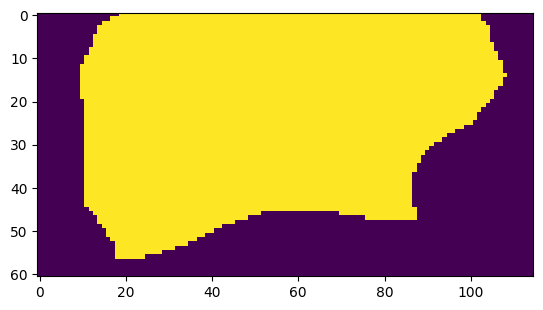

In [12]:
import matplotlib.pyplot as plt
slices,lables = props.values()
print(type(zip(*props.values())))
print(slices[0])
temp = mask[slices[0]]
temp[temp!=lables[0]] = 0
print(temp.shape)
plt.imshow(temp[0])

In [5]:
slices[0]

(slice(0, 23, None), slice(0, 61, None), slice(212, 327, None))

In [6]:
df

,area,centroid-0,centroid-1,intensity_mean-0,intensity_mean-1,label,perimeter,slice,solidity
0,4287.0,23.339631,265.574994,104.145323,318.791929,1,282.953319,"(slice(0, 57, None), slice(222, 321, None))",0.918577
1,1717.0,11.807222,365.828189,111.845079,437.776937,2,198.183766,"(slice(0, 29, None), slice(329, 408, None))",0.948095
2,3497.0,28.863597,443.654275,68.848727,190.416643,3,240.900541,"(slice(0, 72, None), slice(407, 482, None))",0.953641
3,4962.0,43.057840,145.551995,27.669287,84.853890,4,273.178716,"(slice(1, 84, None), slice(106, 190, None))",0.970847
4,3383.0,56.052912,487.861366,208.868756,544.319243,5,262.202056,"(slice(13, 97, None), slice(440, 512, None))",0.901652
...,...,...,...,...,...,...,...,...,...
30,2350.0,492.147234,33.950638,31.967234,130.385532,31,224.195959,"(slice(466, 511, None), slice(0, 79, None))",0.827174
31,1650.0,213.744848,70.218788,49.948485,296.166667,32,171.817280,"(slice(181, 242, None), slice(47, 90, None))",0.883771
32,4875.0,80.364513,261.834051,48.362051,220.006769,33,295.143182,"(slice(45, 124, None), slice(219, 315, None))",0.928571
33,3181.0,174.657655,283.275385,116.214712,676.642251,34,245.072114,"(slice(143, 209, None), slice(244, 327, None))",0.957556


In [3]:
import matplotlib.pyplot as plt
from tifffile import imwrite
value = 14
f = 20
slice_lst = [lst_props[f][value-1].slice for f in range(stack.shape[0])]
area_lst = [lst_props[f][value-1].area_bbox for f in range(stack.shape[0])]    
# sl = sl[::-1]
max_ind = area_lst.index(max(area_lst))
max_slice = slice_lst[max_ind]
print(max_slice)

#crop stack
crop = stack[:,max_slice[0],max_slice[1],:]
crop = np.moveaxis(crop, [-1], [1])
imwrite(f'/home/Test_images/masks/stack_{value}.tif', crop)
# frame = stack[f]
# plt.imshow(frame[sl])
# plt.show()


(slice(181, 301, None), slice(202, 341, None))


In [16]:
from __future__ import annotations
from skimage.measure import regionprops_table, regionprops
from skimage.measure._regionprops import RegionProperties
import numpy as np
from os import PathLike
import pandas as pd
from tifffile import imread
from concurrent.futures import ThreadPoolExecutor
import time


img_path = "/home/Test_images/masks/MAX_Images.tif"
stack_path = "/home/Test_images/masks/MAX_Merged.tif"
mask_path = "/home/Test_images/masks/Masks_IoU_Track.tif"

img = imread(img_path)
stack = imread(stack_path)
stack = np.moveaxis(stack, [1], [-1])
mask = imread(mask_path)


def regionprops_to_df(img_props: RegionProperties)-> pd.DataFrame:
    """
    Read content of all attributes for every item in a list
    output by skimage.measure.regionprops
    """

    attributes_list = ['area','centroid','intensity_mean',
                       'label','perimeter','slice','solidity']

    # Initialise list of lists for parsed data
    parsed_data = []
    # Put data from img_props into list of lists
    for i, img_prop in enumerate(img_props):
        parsed_data += [[]]
        for j in range(len(attributes_list)):
            parsed_data[i] += [getattr(img_prop, attributes_list[j])]
        
    # Return as a Pandas DataFrame
    return pd.DataFrame(parsed_data, columns=attributes_list)
        
def unpack_intensity(df: pd.DataFrame, channels: str | list[str])-> pd.DataFrame:
    """Unpack the intensity values from the regionprops DataFrame and add them as separate columns.
    The original output a tuple of intensities for each channel. This function will simply unpack
    the tuple and add the intensity values as separate columns for each channel.
    
    Args:
        df (pd.DataFrame): DataFrame containing the regionprops output.
        channels (list[str]): List of channel names.
    Returns:
        pd.DataFrame: DataFrame with the unpacked intensity values as separate columns for each channel."""
    
    # If only one channel is present, then the intensity_mean is a float, not a tuple
    if isinstance(df.intensity_mean[0], float):
        if len(channels)!=1:
            raise ValueError("Only one channel is present in the DataFrame. Please provide only 1 channel label.")
        
        if isinstance(channels, list):
            channels = channels[0]
        
        df.rename(columns={'intensity_mean': f'intensity_mean_{channels}'}, inplace=True)
        return df
    
    # If multiple channels are present, then the intensity_mean is a tuple of floats
    if len(channels)!=len(df.intensity_mean[0]):
        raise ValueError(f"The number of channels do not match the number of intensity values. \
            Please add {len(df.intensity_mean[0])} channel labels.")
    
    data = {channels[i]:[intensity[i] for intensity in df.intensity_mean] for i in range(len(channels))}
    attr_ind = df.columns.get_loc('intensity_mean')
    for i, channel in enumerate(channels):
        if i==0:
            df.intensity_mean = data[channel]
            df.rename(columns={'intensity_mean': f"intensity_mean_{channel}"}, inplace=True)
        else:
            df.insert(attr_ind+i, f"intensity_mean_{channel}", data[channel])
    return df

def extract_table(img_array: np.ndarray, mask_array: np.ndarray, channels: list[str], save_path: PathLike)-> pd.DataFrame:
    properties_lst = ['area','centroid','intensity_mean',
                       'label','perimeter','slice','solidity']
    col_rename= {'centroid_0':'centroid_y','centroid_1':'centroid_x'}
    def get_regionprops(frame: int)-> pd.DataFrame:
        """Nested function to extract the regionprops for each frame in multi-threading."""
        prop = regionprops_table(mask_array[frame], intensity_image=img_array[frame],
                                 properties=properties_lst,separator='_')
        df = pd.DataFrame(prop)
        # df = regionprops_to_df(prop)
        df['frame'] = frame+1
        return df

    # If the mask_array is not a time sequence
    if mask_array.ndim ==2:
        prop = regionprops_table(mask_array, intensity_image=img_array,
                                 properties=properties_lst,separator='_')
        master_df = pd.DataFrame(prop)
        master_df['frame'] = 1
        col_rename['intensity_mean'] = f'intensity_mean_{channels[0]}'
        master_df.rename(columns=col_rename, inplace=True)
        # master_df = unpack_intensity(master_df, channels)
        master_df.to_csv(save_path, index=False, header=True)
        return master_df
    
    # If the mask_array is a time sequence
    with ThreadPoolExecutor() as executor:
        lst_df = executor.map(get_regionprops, range(mask_array.shape[0]))
    
    # Create the DataFrame and save to csv
    master_df = pd.concat(lst_df, ignore_index=True)
    col_rename = {**col_rename,**{f'intensity_mean_{i}':f'intensity_mean_{channels[i]}' for i in range(len(channels))}}
    master_df.rename(columns=col_rename, inplace=True)
    master_df.to_csv(save_path, index=False, header=True)
    return master_df

def extract_data(img_array: np.ndarray, mask_array: np.ndarray, channels: list[str], save_path: PathLike)-> pd.DataFrame:
    def get_regionprops(frame: int)-> pd.DataFrame:
        """Nested function to extract the regionprops for each frame in multi-threading."""
        prop = regionprops(mask_array[frame], intensity_image=img_array[frame])
        df = regionprops_to_df(prop)
        df['frame'] = frame+1
        return unpack_intensity(df,channels)

    # If the mask_array is not a time sequence
    if mask_array.ndim ==2:
        prop = regionprops(mask_array, intensity_image=img_array)
        master_df = regionprops_to_df(prop)
        master_df['frame'] = 1
        master_df = unpack_intensity(master_df, channels)
        master_df.to_csv(save_path, index=False, header=True)
        return master_df
    
    # If the mask_array is a time sequence
    with ThreadPoolExecutor() as executor:
        lst_df = executor.map(get_regionprops, range(mask_array.shape[0]))
    
    # Create the DataFrame and save to csv
    master_df = pd.concat(lst_df, ignore_index=True)
    master_df.to_csv(save_path, index=False, header=True)
    return master_df

start = time.time()
master_df = extract_data(stack, mask, ['GFP','RFP'], '/home/Test_images/masks/regionprops.csv')
end1 = time.time()

# lst_df = [regionprops_to_df(prop) for prop in lst_props]
# lst_unpack = [unpack_intensity(df, ['GFP','RFP']) for df in lst_df]
# # Add the frame number to the DataFrame
# for i,df in enumerate(lst_unpack):
#     df['frame'] = i
# master_df = pd.concat(lst_unpack, ignore_index=True)
master_df = extract_table(stack, mask, ["GFP",'RFP'], '/home/Test_images/masks/regionprops.csv')
end2 = time.time()
print(f"Regionprops: {end1-start}, Regionprops_table: {end2-end1}")


Regionprops: 0.6202468872070312, Regionprops_table: 0.6223130226135254


In [17]:
master_df

,area,centroid_y,centroid_x,intensity_mean_GFP,intensity_mean_RFP,label,perimeter,slice,solidity,frame
0,4287.0,23.339631,265.574994,104.145323,318.791929,1,282.953319,"(slice(0, 57, None), slice(222, 321, None))",0.918577,1
1,1717.0,11.807222,365.828189,111.845079,437.776937,2,198.183766,"(slice(0, 29, None), slice(329, 408, None))",0.948095,1
2,3497.0,28.863597,443.654275,68.848727,190.416643,3,240.900541,"(slice(0, 72, None), slice(407, 482, None))",0.953641,1
3,4962.0,43.057840,145.551995,27.669287,84.853890,4,273.178716,"(slice(1, 84, None), slice(106, 190, None))",0.970847,1
4,3383.0,56.052912,487.861366,208.868756,544.319243,5,262.202056,"(slice(13, 97, None), slice(440, 512, None))",0.901652,1
...,...,...,...,...,...,...,...,...,...,...
797,2350.0,492.147234,33.950638,31.967234,130.385532,31,224.195959,"(slice(466, 511, None), slice(0, 79, None))",0.827174,23
798,1650.0,213.744848,70.218788,49.948485,296.166667,32,171.817280,"(slice(181, 242, None), slice(47, 90, None))",0.883771,23
799,4875.0,80.364513,261.834051,48.362051,220.006769,33,295.143182,"(slice(45, 124, None), slice(219, 315, None))",0.928571,23
800,3181.0,174.657655,283.275385,116.214712,676.642251,34,245.072114,"(slice(143, 209, None), slice(244, 327, None))",0.957556,23


In [23]:
df_unpack.iloc[:,-1]

0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
11    11
12    12
13    13
14    14
15    15
16    16
17    17
18    18
19    19
20    20
21    21
22    22
23    23
24    24
25    25
26    26
27    27
28    28
29    29
30    30
31    31
32    32
33    33
34    34
Name: frame, dtype: int64

In [65]:
# One channel
pd.merge(df_img.dtypes.rename('img'), df_stack.dtypes.rename("stack"), left_index=True, right_index=True, how='outer')

,img,stack
area,float64,float64
area_bbox,float64,float64
area_convex,float64,float64
area_filled,float64,float64
axis_major_length,float64,float64
axis_minor_length,float64,float64
bbox,object,object
centroid,object,object
centroid_local,object,object
centroid_weighted,object,object


In [71]:

diff = [np.all(df_img[col].astype(str)==df_stack[col].astype(str)) for col in df_img.columns]


(array([], dtype=int64),)

In [75]:
false_obj = [ind for ind, val in enumerate(diff) if not val]
df_img.columns[false_obj]

Index(['centroid_weighted', 'centroid_weighted_local', 'intensity_max',
       'intensity_mean', 'intensity_min', 'moments_weighted',
       'moments_weighted_central', 'moments_weighted_hu',
       'moments_weighted_normalized'],
      dtype='object')

In [13]:
df_img.centroid_weighted[0]

(24.982012269553902, 264.5472852660083)

In [14]:
df_stack.centroid_weighted[0]


(array([24.98201227, 24.97970162]), array([264.54728527, 265.99826511]))

In [51]:
for arr in df_stack.moments_weighted_hu[0]:
    print(arr)
    for i,ch in enumerate(['RFP','GFP']):
        print(arr[i])

[0.0018943 0.0006341]
0.0018942986301878331
0.0006341037549663308
[9.23318944e-07 1.01381019e-07]
9.233189436959841e-07
1.0138101859811246e-07
[4.60035118e-10 1.58609429e-11]
4.6003511824314207e-10
1.586094288682459e-11
[8.41221557e-11 1.99255781e-12]
8.412215574205486e-11
1.9925578138452377e-12
[1.37423627e-20 4.29683440e-24]
1.3742362696434462e-20
4.2968343962112716e-24
[5.69427422e-14 1.84800426e-16]
5.694274224861307e-14
1.8480042642766522e-16
[-9.21972930e-21 -1.03447349e-23]
-9.219729304438005e-21
-1.034473491741686e-23


In [143]:
channels = ['RFP','GFP']
data = {ch:[intensity[i] for intensity in df_stack.intensity_mean] for i,ch in enumerate(channels)}
data

{'RFP': [104.14532306974574,
  111.84507862550961,
  68.84872748069775,
  27.669286577992747,
  208.86875554241797,
  75.60394120497496,
  63.55848623853211,
  104.85850091407679,
  62.541935483870965,
  177.34037692747,
  93.77170077628793,
  226.53812858052197,
  29.87294801641587,
  126.10680190930788,
  34.616766467065865,
  107.04249291784703,
  37.65494685200327,
  43.914897544766475,
  34.178768577494694,
  46.36316821971555,
  80.00132450331125,
  59.817541528239204,
  243.46511627906978,
  23.722823733217844,
  21.60587002096436,
  60.8152216555512,
  250.25993985967256,
  32.487752161383284,
  26.814723926380367,
  31.904761904761905,
  49.587434554973825,
  43.13833992094862,
  100.89289289289289,
  20.392692146157078],
 'GFP': [318.7919290879403,
  437.7769365171811,
  190.4166428367172,
  84.85388956066102,
  544.3192432751995,
  274.6073332256501,
  221.4631116207951,
  359.5405850091408,
  172.05868886576482,
  430.3569388920617,
  378.3345095271701,
  670.4728198599618,

In [139]:
channels = ['RFP','GFP']
data = {ch:[] for ch in channels}
for value in df_stack.moments_weighted:
    for i,ch in enumerate(channels):
        data[ch].append([array[:,i] for array in value])

data['RFP'][0]
    

[array([4.46471000e+05, 1.89961290e+07, 1.09128561e+09, 7.17942555e+10]),
 array([1.11537440e+07, 4.57566243e+08, 2.51328193e+10, 1.57843690e+12]),
 array([3.73193660e+08, 1.48338280e+10, 7.90001891e+11, 4.81584118e+13]),
 array([1.41625400e+10, 5.43401033e+11, 2.82109007e+13, 1.68592945e+15])]

In [119]:
channels = ['RFP','GFP']
lst = [list(zip(*df_stack.centroid_weighted_local[i])) for i in range(len(df_stack.centroid_weighted))]
data = {channels[i]: [el[i] for el in lst] for i in range(len(channels))}
data["RFP"]

[(24.982012269553902, 42.547285266008316),
 (13.197690040512816, 38.964444537018714),
 (29.382079546776097, 43.77340050838165),
 (44.265129829928256, 39.17692559816454),
 (44.28852269237464, 46.6409836923987),
 (40.40545523689068, 56.13999367607848),
 (37.87497970156794, 51.744868255658),
 (35.553475040796684, 54.39356074870636),
 (41.75416785906813, 42.533941846303335),
 (16.729569146246817, 30.636725781987163),
 (58.04245171195376, 35.31709620732345),
 (39.06850853940275, 79.17910576091471),
 (39.26430906083104, 54.82176568573015),
 (53.96295237869934, 62.891174564121975),
 (31.430135856186713, 20.719784971990475),
 (54.169570740485895, 83.12787871169216),
 (37.613617939141264, 43.49843654998697),
 (37.34540348989226, 50.71862270741991),
 (38.18072828018039, 20.58874905268912),
 (37.8604530621096, 41.47934352009055),
 (71.77229681627787, 72.14714436295205),
 (62.092604975929014, 45.43910718530548),
 (36.3248077847371, 33.57521753567221),
 (33.87264495399445, 22.377756681758434),
 (34

In [54]:
import numpy as np
import time
start = time.time()
for value in np.unique(mask):
    is_complete = np.all(np.any(mask==value, axis=(1,2)))
    if not is_complete:
        print(value)
end = time.time()
print((end-start))


30
0.15466690063476562


In [64]:
start = time.time()
lst_obj = [np.unique(frame) for frame in mask]
lst_obj = np.concatenate(lst_obj)
# lst_obj = [item for sublst in lst_obj for item in sublst]
value,cnt = np.unique(lst_obj,return_counts=True)
obj_to_delete = value[cnt!=23]
for value in obj_to_delete:
    print(value)
# for obj, cnt in np.unique(lst_obj,return_counts=True):
#     if cnt!=23:
#         print(obj)
end = time.time()
print((end-start))

30
0.04352402687072754


In [67]:
def trim_incomplete_track(array: np.ndarray)-> np.ndarray:
    """Function to trim the incomplete tracks from the mask stack.
    Args:
        array (np.ndarray): 3D Mask array in tyx format.
    Returns:
        np.ndarray: Mask array with incomplete tracks removed."""
    # Make a list of unique objects
    lst_obj = [np.unique(frame) for frame in array]
    lst_obj = np.concatenate(lst_obj) # Flatten the list
    # Count the number of occurences of each object
    obj,cnt = np.unique(lst_obj,return_counts=True)
    # Create a list of obj to remove
    obj_to_remove = obj[cnt!=20]
    for obj in obj_to_remove:
        array[array==obj] = 0
    return array
start = time.time()
mask = imread(mask_path)

lst_obj = [np.unique(frame) for frame in mask]
lst_obj = np.concatenate(lst_obj)
# lst_obj = [item for sublst in lst_obj for item in sublst]
value,cnt = np.unique(lst_obj,return_counts=True)
obj_to_delete = value[cnt!=20]
print("Before: ",obj_to_delete)

mask = trim_incomplete_track(mask)

lst_obj = [np.unique(frame) for frame in mask]
lst_obj = np.concatenate(lst_obj)
# lst_obj = [item for sublst in lst_obj for item in sublst]
value,cnt = np.unique(lst_obj,return_counts=True)
obj_to_delete = value[cnt!=20]
print("After: ",obj_to_delete)
end = time.time()
print((end-start))

Before:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 31 32 33 34 35]
After:  [0]
0.1704254150390625


In [5]:
import numpy as np
maskNum = 35
intensity = np.nanmean(a=img,where=mask==maskNum)
intensity
print(intensity, prop[maskNum-1].intensity_mean)

117.43083573487031 117.43083573487031


In [4]:
from sys import getsizeof
getsizeof(prop)

424

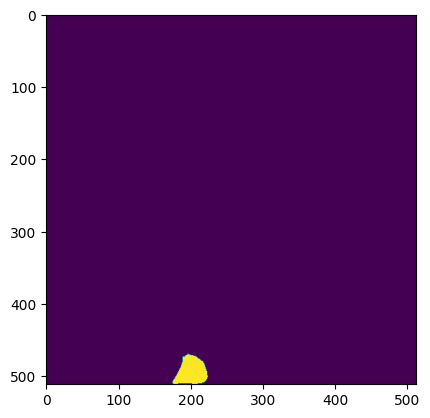

In [6]:
from matplotlib.pyplot import imshow
temp = mask.copy()
temp[temp!=maskNum] = 0
imshow(temp)

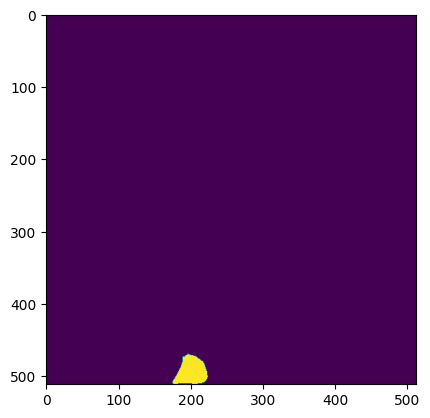

In [17]:
new_mask = np.zeros_like(mask)


value = prop[maskNum-1].coords.tolist()
for y,x in prop[maskNum-1].coords:
    new_mask[y,x] = maskNum
imshow(new_mask)

In [5]:
from importlib.metadata import version

version('ImageAnalysis')

import pkg_resources

def get_version():
    try:
        return pkg_resources.get_distribution("ImageAnalysis").version
    except pkg_resources.DistributionNotFound:
        return "Package not found"
print(get_version())

1.0.0


/tmp/ipykernel_79033/3457485119.py:5: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [50]:
d2 = {'a':1, 'b':5}
d1 = {'a':1, 'b':2, 'c':3}
d = {**d1, **d2}
d

{'a': 1, 'b': 5, 'c': 3}

In [15]:
from os import sep
input_fold = '/home/Test_images/nd2/Run2'
parent_path = input_fold.rsplit(sep,1)[0]
img_path = '/home/Test_images/nd2/Run2/treated/100mg/c2z25t23v1_nd2.nd2'
img = img_path.replace(parent_path,'').split(sep)[1:-1]
print(img)

['Run2', 'treated', '100mg']


In [4]:
from tifffile import imread
import numpy as np
img_paths = ['/home/Test_images/nd2/Run3/c3z1t1v3_s1/Masks_Cellpose/RFP_s01_f0001_z0001.tif']
frame_range = range(1)
channels = ['RFP']
exp_list = []
for chan in channels:
    chan_list = []
    for frame in frame_range:
        f_lst = []
        for path in img_paths:
            if chan in path and path.__contains__(f'_f%04d'%(frame+1)):
                f_lst.append(imread(path))
        chan_list.append(f_lst)
    exp_list.append(chan_list)
np.squeeze(np.array(exp_list)).shape

(1024, 1024)

In [16]:
from os import listdir
import re
scan = listdir('/home/Test_images/bigy/HEKA_c1031_c1829_miniSOG_80%_435_2min_40min_002_Merged_s1/Images')
# frames = [re.search('f\d{4}', frame).group() for frame in scan if re.search('f\d{4}', frame)]
# len(set(frames))
channel_seg = "GFP"
file_type = '.tif'
any(channel_seg in file for file in scan if file.endswith(file_type))

False

In [13]:
d = {'b':1}

if d and 'a' in d:
    print('yes')
else:
    print('no')

no


In [6]:
import json
good = '/home/Test_images/bigy/HEKA_c1031_c1829_miniSOG_80%_435_2min_40min_002_Merged_s1/exp_settings.json'

with open(good,'r') as fp:
    meta = json.load(fp)
meta['segmentation']['cellpose_seg']['RFP']['cellpose_eval']

{'batch_size': 8,
 'resample': True,
 'channels': [0, 0],
 'channel_axis': None,
 'z_axis': None,
 'normalize': {'percentile': [1, 99]},
 'invert': False,
 'rescale': None,
 'diameter': 30.0,
 'flow_threshold': 0.5,
 'cellprob_threshold': 0,
 'do_3D': False,
 'anisotropy': None,
 'stitch_threshold': 0.0,
 'min_size': 15,
 'niter': None,
 'augment': False,
 'tile': True,
 'tile_overlap': 0.1,
 'bsize': 224,
 'interp': True,
 'compute_masks': True,
 'progress': None}

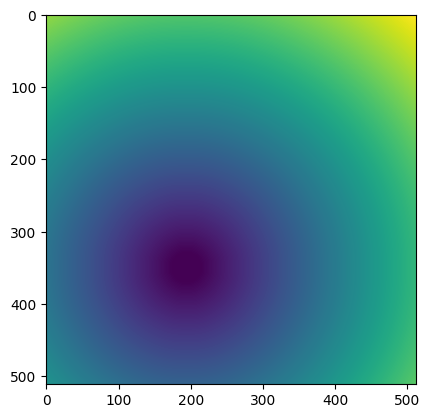

In [90]:
from tifffile import imread, imwrite
import numpy as np
from skimage.draw import disk
import matplotlib.pyplot as plt
from skimage.measure import regionprops_table, regionprops
from mahotas import distance
from scipy.ndimage import distance_transform_edt

mask_path = '/home/Test_images/masks/Masks_IoU_Track.tif'
mask = imread(mask_path)
ref = np.ones_like(mask)
rr,cc = disk((350, 194), 20,)
ref[:,rr,cc] = 0
# ref = distance(ref,metric='euclidean')
ref = distance_transform_edt(ref)

imwrite('/home/Test_images/masks/mask_ref.tif', ref.astype('uint16'))
plt.imshow(ref[0])

In [94]:
mm = mask.copy()
mm[5,...][mm[5,...]==14] = 14
print(mm.shape)

(23, 512, 512)


In [97]:
lst = [np.unique(mm[i]) for i in range(mm.shape[0])]
obj_lst,cnt = np.unique(np.concatenate(lst),return_counts=True)
print(obj_lst,cnt)
# nc = [len(np.where(mask==i)) for i in obj_lst]
complete_track = obj_lst[cnt!=mm.shape[0]]
complete_track.size

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 31 32 33 34 35 37] [23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23
 23 23 23 23 23 23 23 23 23 23 23 23]


0

In [52]:
m1 = mask.copy()
m1[0] = 0
m1[-1] = 0
m1[m1!=14] = 0
props = zip(*regionprops_table(m1,properties=['slice','label']).values())
slice_obj,label = props
ref_f = slice(0,23)
obj_slice = (ref_f,*(slice_obj[1:]))
print(obj_slice)
temp = m1[obj_slice]
print(temp.shape)
# print(type(slice_obj[0]))
# obj1 = slice_obj[0]
# f,y,x = obj1
# # f = slice(0,23)
# print(f)
# obj2 = tuple((f,y,x))
# print(type(obj2))
# props['slice'] = np.array(obj2).astype(tuple)
# print(props)
# slice_obj = props['slice']
# print(type(slice_obj[0]))
# obj1==obj2

TypeError: 'zip' object is not subscriptable

In [25]:
def centroid_intensity(region, intensity_image):
    # Calculate the centroid coordinates as integers
    y, x = np.nonzero(region)
    y, x = int(np.mean(y)), int(np.mean(x))
    # Return the intensity at the centroid position
    return int(intensity_image[y,x])
poop = {}
prop = regionprops_table(mask[0], intensity_image=ref[0], properties=['label','mean_intensity'],extra_properties=[centroid_intensity])
poop['dmap'] = prop['centroid_intensity']*.32
poop

{'dmap': array([100.48, 115.2 , 123.84,  93.12, 126.4 , 104.32,  72.32, 108.8 ,
         72.96,  91.84,  54.72,  72.32,  54.08,  37.76,  60.16,  63.68,
         48.  ,  31.04,  49.6 ,  35.84,  81.6 ,  42.24,  26.88,  22.4 ,
         30.08,  43.84,  37.12,  39.68,  62.4 ,  53.76,  85.44,  52.48,
         82.88,  56.32,  65.28])}

In [29]:
def centroid_intensity(region, intensity_image):
    # Calculate the centroid coordinates as integers
    y, x = np.nonzero(region)
    # Return the intensity at the centroid position
    return intensity_image[int(np.mean(y)), int(np.mean(x))]
m1 = mask[0].copy()
m1[m1!=14] = 0
y,x = np.nonzero(m1)
y,x = int(np.mean(y)), int(np.mean(x))
print(y,x)
ref[0,y,x]
centroid_intensity(m1,ref[0])

232 266


118.51160280748886

In [51]:
from os import scandir

path = '/home/Test_images/bigy/HEKA_c1031_c1829_miniSOG_80%_435_2min_40min_003_Merged_s1/test'
any(scandir(path))

False

In [17]:
from os import listdir
channel_seg = 'GFP'
s = '/home/Test_images/tiff/Run2/c2z25t23v1_tif_s1/Images_Registered'
any(channel_seg in file for file in sorted(listdir(s)) if file.endswith('.tif'))

True

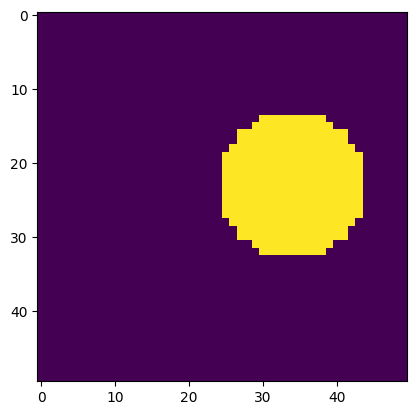

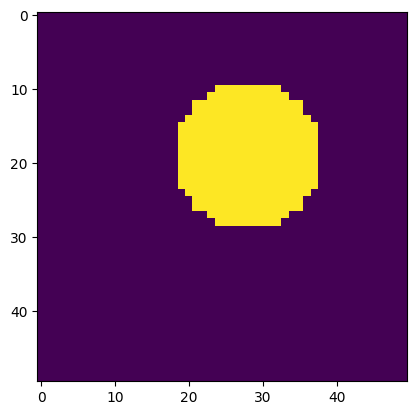

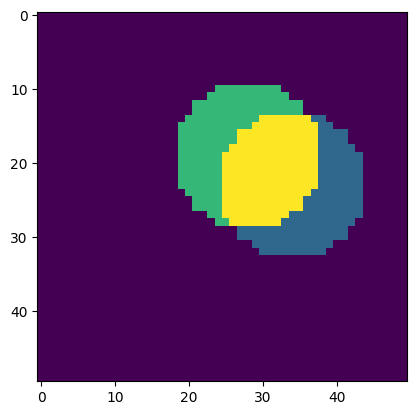

In [74]:
import numpy as np
from skimage.draw import disk
import matplotlib.pyplot as plt

mask1 = np.zeros((50,50),dtype=np.uint8)
rr,cc = disk((23,34),10)
mask1[rr,cc] = 1
mask2 = np.zeros((50,50),dtype=np.uint8)
rr,cc = disk((19,28),10)
mask2[rr,cc] = 2
plt.imshow(mask1)
plt.show()
plt.imshow(mask2)
plt.show()
# zero_arr = mask1==0
# mask1[zero_arr] += mask2[zero_arr]
mask1 += mask2
plt.imshow(mask1)
plt.show()

In [30]:
from pystackreg import StackReg
from tifffile import imread, imwrite
from os.path import join
from os import listdir
from pipeline.image_handeling.data_utility import load_stack
from warnings import filterwarnings
filterwarnings("ignore")

input_fold = "/home/Test_images/szimi/fish_jumpy/BF_3dpf_fish_hypo_100uMfMLF@5min_003_s1"
img_files = [join(input_fold,'Images',path) for path in sorted(listdir(join(input_fold,'Images')))]
# img_files = [imread(img) for img in img_files]
frames = 61
zs = 5

sr = StackReg(StackReg.RIGID_BODY)
img = load_stack(img_files, 'BF', range(frames), True)
tmats = sr.register_stack(img,reference='mean')
reg = sr.transform_stack(img)
imwrite(join(input_fold,"Test","reg.tif"), reg.astype('uint16'))

In [34]:
d_tmats = {i:tmats[i] for i in range(len(tmats))}
print(tmats.shape)

(61, 3, 3)


In [20]:
import numpy as np

ff = [file for file in img_files if "_f0001" in file]
rf = [file for file in img_files if "_f0001" not in file]

imgs = [imread(file) for file in rf]
sr = StackReg(StackReg.RIGID_BODY)
regs = [sr.transform(img, tmats) for img in imgs]
reg = np.stack(regs)
imwrite(join(input_fold,"Test","reg.tif"), reg.astype('uint16'))


In [9]:
from pipeline.pre_process.image_registration import get_tmats_previous, get_frame_from_path

sr = StackReg(StackReg.RIGID_BODY)
tmats = get_tmats_previous(img_files, frames, sr, 'BF')

In [16]:
tmats
get_frame_from_path(rf[0])

1

In [26]:
from pipeline.pre_process.image_registration import apply_tmat_to_img
import numpy as np

sr = StackReg(StackReg.RIGID_BODY)
metadata = {'um_per_pixel':None,'finterval':None}
lst = [apply_tmat_to_img(file, sr,d_tmats,metadata, "Test") for file in img_files]